# News classification based on category

This notebook implements text classification using Tensorflow.

Dataset used:
"News Category Dataset" by Rishabh Misra from kaggle
https://www.kaggle.com/rmisra/news-category-dataset 

While working on this notebook, i took some ideas from mrdbourke's Tensorflow deep learning course:
https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb


#Load and analyze text data

In [1]:
# unzip data
import zipfile

zip = zipfile.ZipFile("archive.zip")
zip.extractall()

In [2]:
# file is in .json format, let's use json library to read it
import json

# open file
f = open("/content/News_Category_Dataset_v2.json")

# get json strings
json_strings = f.readlines()

# turn json strings into list of dictionaries
data = []
for string in json_strings:
  data.append(json.loads(string))

# close file
f.close()

In [3]:
# view samples
data[:3]

[{'authors': 'Melissa Jeltsen',
  'category': 'CRIME',
  'date': '2018-05-26',
  'headline': 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV',
  'link': 'https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89',
  'short_description': 'She left her husband. He killed their children. Just another day in America.'},
 {'authors': 'Andy McDonald',
  'category': 'ENTERTAINMENT',
  'date': '2018-05-26',
  'headline': "Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song",
  'link': 'https://www.huffingtonpost.com/entry/will-smith-joins-diplo-and-nicky-jam-for-the-official-2018-world-cup-song_us_5b09726fe4b0fdb2aa541201',
  'short_description': 'Of course it has a song.'},
 {'authors': 'Ron Dicker',
  'category': 'ENTERTAINMENT',
  'date': '2018-05-26',
  'headline': 'Hugh Grant Marries For The First Time At Age 57',
  'link': 'https://www.huffingtonpost.com/entry/hugh-grant-marries_us_5b09212ce4b0568a880b9a8

In [4]:
# turn our list of dictionaries into pandas dataframe
import pandas as pd

df = pd.DataFrame(data)
df = df.sample(frac = 1) # shuffle dataframe

# view first 5 samples
df.head()

,category,headline,authors,link,short_description,date
174199,SCIENCE,Curiosity Rover Team Shifts Back To Earth Time...,,https://www.huffingtonpost.com/entry/curiosity...,By: SPACE.com Staff Published: 11/09/2012 08:1...,2012-11-10
47235,COMEDY,Your Grandparents Want To Tell You Not To Vote...,Andy McDonald and Carol Kuruvilla,https://www.huffingtonpost.com/entry/your-gran...,They will literally haunt you.,2016-09-23
96833,WORLDPOST,Cubans Demand a Direct and Secret Ballot to El...,"Yoani Sanchez, ContributorPublisher of 14ymedi...",https://www.huffingtonpost.com/entry/cubans-de...,"Among the notable absences in the discussion, ...",2015-03-08
2725,ENTERTAINMENT,Jaime King's 4-Year-Old Son Hit With Broken Gl...,Ron Dicker,https://www.huffingtonpost.com/entry/jaime-kin...,Police said they charged a man who smashed the...,2018-04-05
200452,HOME & LIVING,Color Palette: Shades Of Style From Our Favori...,Dickson Wong,https://www.huffingtonpost.com/entry/color-pal...,It goes without saying that we look to everyth...,2012-02-01


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200853 entries, 174199 to 12762
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   category           200853 non-null  object
 1   headline           200853 non-null  object
 2   authors            200853 non-null  object
 3   link               200853 non-null  object
 4   short_description  200853 non-null  object
 5   date               200853 non-null  object
dtypes: object(6)
memory usage: 10.7+ MB


# News classification based on short description

as we can see, each row of the dataframe contains news headline and short description.

let's first try to build a model that predicts news category based on only short description

Prepare data

In [6]:
# get features and labels from pandas dataframe
X = df["short_description"].values
y = df["category"].values

In [7]:
# split our data into train(80%) and test(20%) subsets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

len(X_train), len(y_train), len(X_test), len(y_test)

(160682, 160682, 40171, 40171)

In [8]:
# use one-hot-encoding to turn string labels into numbers
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# define one-hot encoder
enc = OneHotEncoder(sparse = False)
# fit one-hot encoder
enc.fit(np.expand_dims(y_train, 1))

# encode train and labels data
y_train_one_hot = enc.transform(np.expand_dims(y_train, 1))
y_test_one_hot = enc.transform(np.expand_dims(y_test, 1))

# get class names
class_names = enc.get_feature_names()

# sklearn appends 'x0_' string in the start of feature names, let's remove those
for n, class_name in enumerate(class_names): 
  class_names[n] = class_name[3:]

In [9]:
class_names

array(['ARTS', 'ARTS & CULTURE', 'BLACK VOICES', 'BUSINESS', 'COLLEGE',
       'COMEDY', 'CRIME', 'CULTURE & ARTS', 'DIVORCE', 'EDUCATION',
       'ENTERTAINMENT', 'ENVIRONMENT', 'FIFTY', 'FOOD & DRINK',
       'GOOD NEWS', 'GREEN', 'HEALTHY LIVING', 'HOME & LIVING', 'IMPACT',
       'LATINO VOICES', 'MEDIA', 'MONEY', 'PARENTING', 'PARENTS',
       'POLITICS', 'QUEER VOICES', 'RELIGION', 'SCIENCE', 'SPORTS',
       'STYLE', 'STYLE & BEAUTY', 'TASTE', 'TECH', 'THE WORLDPOST',
       'TRAVEL', 'WEDDINGS', 'WEIRD NEWS', 'WELLNESS', 'WOMEN',
       'WORLD NEWS', 'WORLDPOST'], dtype=object)

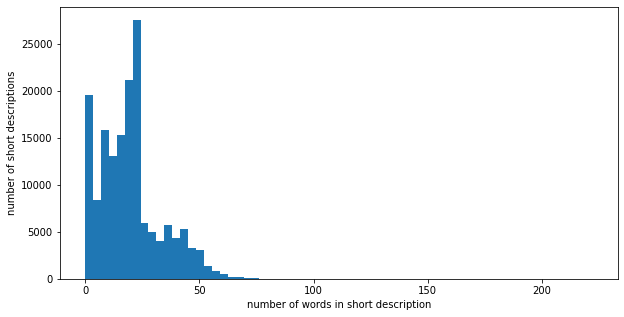

99% of the descriptions are shorter than 57 words


In [10]:
# check distribution of number of words in short descriptions
import matplotlib.pyplot as plt

n_words = []

for description in X_train:
  n_words.append(len(description.split()))

n_words = np.sort(n_words)
plt.figure(figsize = (10,5))
plt.hist(n_words, bins = 64)
plt.xlabel("number of words in short description")
plt.ylabel("number of short descriptions")
plt.show()

description_max_length = int(np.percentile(n_words, 99))
print(f"99% of the descriptions are shorter than {description_max_length} words")

In [11]:
# use tf.keras.layers.TextVectorization to turn sentences into sequence of numbers
import tensorflow as tf

vocab_size = 1000

short_description_vectorizer = tf.keras.layers.TextVectorization(max_tokens = vocab_size, 
                                                                 output_sequence_length = description_max_length)
short_description_vectorizer.adapt(X_train)

In [12]:
# use embedding layer that turns words into fixed sized vectors to capture their meaning while training

short_description_embedding = tf.keras.layers.Embedding(input_dim = vocab_size,
                                            output_dim = 128,
                                            input_length = description_max_length
                                            )

In [13]:
# prepare datasets
train_values = tf.data.Dataset.from_tensor_slices(X_train)
train_labels = tf.data.Dataset.from_tensor_slices(y_train_one_hot)
train_dataset = tf.data.Dataset.zip((train_values, train_labels))

# batch and prefetch to optimize performance
train_dataset = train_dataset.batch(32).prefetch(buffer_size = tf.data.AUTOTUNE)

# do same for test data
test_values = tf.data.Dataset.from_tensor_slices(X_test)
test_labels = tf.data.Dataset.from_tensor_slices(y_test_one_hot)
test_dataset = tf.data.Dataset.zip((test_values, test_labels))

test_dataset = test_dataset.batch(32).prefetch(buffer_size = tf.data.AUTOTUNE)

create first model that uses embeddings and conv1D layer

In [14]:
# create model
inputs = tf.keras.layers.Input(shape = (1,), dtype = tf.string, name = "input_layer")
x = short_description_vectorizer(inputs)
x = short_description_embedding(x)
x = tf.keras.layers.Conv1D(filters = 16, kernel_size = 5)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(len(class_names), activation = "softmax", name = "output_layer")(x)

model_descriptions_conv1D = tf.keras.Model(inputs, outputs)

# compile model
model_descriptions_conv1D.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                                  loss = tf.keras.losses.categorical_crossentropy,
                                  metrics = ["accuracy"])

# check model summary
model_descriptions_conv1D.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 57)                0         
_________________________________________________________________
embedding (Embedding)        (None, 57, 128)           128000    
_________________________________________________________________
conv1d (Conv1D)              (None, 53, 16)            10256     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
output_layer (Dense)         (None, 41)                697       
Total params: 138,953
Trainable params: 138,953
Non-trainable params: 0
_______________________________________________________

In [15]:
# fit model
history_descriptions_conv1D = model_descriptions_conv1D.fit(train_dataset,
                                                            epochs = 5,
                                                            steps_per_epoch = int(0.1 * len(train_dataset)), # use 10% of train data for experimentation
                                                            validation_data = test_dataset,
                                                            validation_steps = int(0.2*len(test_dataset)) # use 20% of test data for validation
                                                            )

Epoch 1/5
502/502 [==============================] - 35s 10ms/step - loss: 3.2384 - accuracy: 0.1899 - val_loss: 3.1161 - val_accuracy: 0.2058
Epoch 2/5
502/502 [==============================] - 5s 10ms/step - loss: 3.0678 - accuracy: 0.2209 - val_loss: 3.0032 - val_accuracy: 0.2322
Epoch 3/5
502/502 [==============================] - 5s 9ms/step - loss: 2.9822 - accuracy: 0.2451 - val_loss: 2.9126 - val_accuracy: 0.2646
Epoch 4/5
502/502 [==============================] - 5s 10ms/step - loss: 2.9199 - accuracy: 0.2679 - val_loss: 2.8470 - val_accuracy: 0.2856
Epoch 5/5
502/502 [==============================] - 5s 9ms/step - loss: 2.8467 - accuracy: 0.2900 - val_loss: 2.8007 - val_accuracy: 0.2988


In [16]:
# evaluate model using test data
descriptions_Conv1D_results = model_descriptions_conv1D.evaluate(test_dataset)

1256/1256 [==============================] - 6s 5ms/step - loss: 2.8139 - accuracy: 0.2988


create model using LSTM layer

In [17]:
# recreate embedding layer so it doesn't use weights that it got from training on conv1D model
short_description_embedding = tf.keras.layers.Embedding(input_dim = vocab_size,
                                            output_dim = 128,
                                            input_length = description_max_length
                                            )

In [18]:
# create model
inputs = tf.keras.layers.Input(shape = (1,), dtype = tf.string, name = "input_layer")
x = short_description_vectorizer(inputs)
x = short_description_embedding(x)
x = tf.keras.layers.LSTM(128)(x)
outputs = tf.keras.layers.Dense(len(class_names), activation = "softmax", name = "output_layer")(x)

model_descriptions_LSTM = tf.keras.Model(inputs, outputs)

# compile model
model_descriptions_LSTM.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                                  loss = tf.keras.losses.categorical_crossentropy,
                                  metrics = ["accuracy"])

# check model summary
model_descriptions_LSTM.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 57)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 57, 128)           128000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
output_layer (Dense)         (None, 41)                5289      
Total params: 264,873
Trainable params: 264,873
Non-trainable params: 0
_________________________________________________________________


In [19]:
history_descriptions_LSTM = model_descriptions_LSTM.fit(train_dataset,
                                                        epochs = 5,
                                                        steps_per_epoch = int(0.1 * len(train_dataset)), # use 10% of train data for experimentation
                                                        validation_data = test_dataset,
                                                        validation_steps = int(0.2*len(test_dataset)) # use 20% of test data for validation
                                                        )

Epoch 1/5
502/502 [==============================] - 16s 26ms/step - loss: 3.2659 - accuracy: 0.1764 - val_loss: 3.1800 - val_accuracy: 0.1981
Epoch 2/5
502/502 [==============================] - 13s 25ms/step - loss: 3.1094 - accuracy: 0.2150 - val_loss: 3.0722 - val_accuracy: 0.2114
Epoch 3/5
502/502 [==============================] - 13s 25ms/step - loss: 3.0494 - accuracy: 0.2110 - val_loss: 3.0394 - val_accuracy: 0.2199
Epoch 4/5
502/502 [==============================] - 13s 26ms/step - loss: 3.0265 - accuracy: 0.2159 - val_loss: 2.9809 - val_accuracy: 0.2280
Epoch 5/5
502/502 [==============================] - 13s 26ms/step - loss: 2.9919 - accuracy: 0.2234 - val_loss: 2.9493 - val_accuracy: 0.2258


In [20]:
# evaluate lstm model using test data
descriptions_LSTM_results = model_descriptions_LSTM.evaluate(test_dataset)

1256/1256 [==============================] - 11s 9ms/step - loss: 2.9680 - accuracy: 0.2219


# News classification based on headline

Let's build a model that classifies news by category based on only headline

In [21]:
# get features and labels from dataframe

X = df["headline"].values
y = df["category"].values 

In [22]:
# split our data into train(80%) and test(20%) subsets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

len(X_train), len(y_train), len(X_test), len(y_test)

(160682, 160682, 40171, 40171)

In [23]:
# use one-hot-encoding to turn string labels into numbers
from sklearn.preprocessing import OneHotEncoder
import numpy as np

enc = OneHotEncoder(sparse = False)
enc.fit(np.expand_dims(y_train, 1))

y_train_one_hot = enc.transform(np.expand_dims(y_train, 1))
y_test_one_hot = enc.transform(np.expand_dims(y_test, 1))

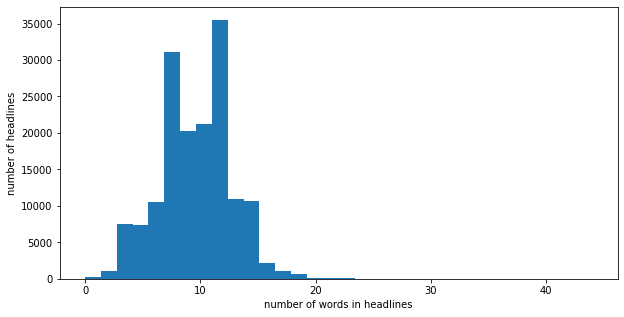

99% of the headlines are shorter than 17 words


In [24]:
# check distribution of number of words in headlines

n_words = []

for description in X_train:
  n_words.append(len(description.split()))

n_words = np.sort(n_words)
plt.figure(figsize = (10,5))
plt.hist(n_words, bins = 32)
plt.xlabel("number of words in headlines")
plt.ylabel("number of headlines")
plt.show()

headline_max_length = int(np.percentile(n_words, 99))
print(f"99% of the headlines are shorter than {headline_max_length} words")

In [25]:
# use tf.keras.layers.TextVectorization to turn sentences into sequence of numbers
import tensorflow as tf

vocab_size = 1000

headline_vectorizer = tf.keras.layers.TextVectorization(max_tokens = vocab_size, 
                                                        output_sequence_length = headline_max_length)
headline_vectorizer.adapt(X_train)

In [26]:
# use embedding layer that turns words into fixed sized vectors to capture their meaning while training

headline_embedding = tf.keras.layers.Embedding(input_dim = vocab_size,
                                            output_dim = 128,
                                            input_length = headline_max_length
                                            )

In [27]:
# prepare datasets
train_values = tf.data.Dataset.from_tensor_slices(X_train)
train_labels = tf.data.Dataset.from_tensor_slices(y_train_one_hot)
train_dataset = tf.data.Dataset.zip((train_values, train_labels))

# batch and prefetch to optimize performance
train_dataset = train_dataset.batch(32).prefetch(buffer_size = tf.data.AUTOTUNE)

# do same for test data
test_values = tf.data.Dataset.from_tensor_slices(X_test)
test_labels = tf.data.Dataset.from_tensor_slices(y_test_one_hot)
test_dataset = tf.data.Dataset.zip((test_values, test_labels))

test_dataset = test_dataset.batch(32).prefetch(buffer_size = tf.data.AUTOTUNE)

Create model using Conv1D layer

In [28]:
# create model
inputs = tf.keras.layers.Input(shape = (1,), dtype = tf.string, name = "input_layer")
x = headline_vectorizer(inputs)
x = headline_embedding(x)
x = tf.keras.layers.Conv1D(filters = 16, kernel_size = 5)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(len(class_names), activation = "softmax", name = "output_layer")(x)

model_headlines_conv1D = tf.keras.Model(inputs, outputs)

# compile model
model_headlines_conv1D.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                                  loss = tf.keras.losses.categorical_crossentropy,
                                  metrics = ["accuracy"])

# check model summary
model_headlines_conv1D.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 17)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 17, 128)           128000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 13, 16)            10256     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
output_layer (Dense)         (None, 41)                697       
Total params: 138,953
Trainable params: 138,953
Non-trainable params: 0
_____________________________________________________

In [29]:
# fit model
history_headlines_conv1D = model_headlines_conv1D.fit(train_dataset,
                                                      epochs = 5,
                                                      steps_per_epoch = int(0.1 * len(train_dataset)), # use 10% of train data for experimentation
                                                      validation_data = test_dataset,
                                                      validation_steps = int(0.2*len(test_dataset)) # use 20% of test data for validation
                                                      )

Epoch 1/5
502/502 [==============================] - 6s 10ms/step - loss: 3.1741 - accuracy: 0.2009 - val_loss: 2.9467 - val_accuracy: 0.2560
Epoch 2/5
502/502 [==============================] - 5s 9ms/step - loss: 2.8139 - accuracy: 0.2875 - val_loss: 2.7058 - val_accuracy: 0.3165
Epoch 3/5
502/502 [==============================] - 5s 9ms/step - loss: 2.6543 - accuracy: 0.3275 - val_loss: 2.5760 - val_accuracy: 0.3456
Epoch 4/5
502/502 [==============================] - 5s 9ms/step - loss: 2.5392 - accuracy: 0.3633 - val_loss: 2.4732 - val_accuracy: 0.3733
Epoch 5/5
502/502 [==============================] - 5s 9ms/step - loss: 2.4350 - accuracy: 0.3809 - val_loss: 2.4134 - val_accuracy: 0.3902


In [30]:
# evaluate model on test data
headlines_conv1D_results = model_headlines_conv1D.evaluate(test_dataset)

1256/1256 [==============================] - 5s 4ms/step - loss: 2.4153 - accuracy: 0.3877


Create model using LSTM layer

In [31]:
# recreate embedding layer
headline_embedding = tf.keras.layers.Embedding(input_dim = vocab_size,
                                            output_dim = 128,
                                            input_length = headline_max_length
                                            )

In [32]:
# create model
inputs = tf.keras.layers.Input(shape = (1,), dtype = tf.string, name = "input_layer")
x = headline_vectorizer(inputs)
x = headline_embedding(x)
x = tf.keras.layers.LSTM(64)(x)
outputs = tf.keras.layers.Dense(len(class_names), activation = "softmax", name = "output_layer")(x)

model_headlines_LSTM = tf.keras.Model(inputs, outputs)

# compile model
model_headlines_LSTM.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                                  loss = tf.keras.losses.categorical_crossentropy,
                                  metrics = ["accuracy"])

# check model summary
model_headlines_LSTM.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 17)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 17, 128)           128000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
output_layer (Dense)         (None, 41)                2665      
Total params: 180,073
Trainable params: 180,073
Non-trainable params: 0
_________________________________________________________________


In [33]:
# fit model
history_headlines_LSTM = model_headlines_LSTM.fit(train_dataset,
                                                  epochs = 5,
                                                  steps_per_epoch = int(0.1 * len(train_dataset)), # use 10% of train data for experimentation
                                                  validation_data = test_dataset,
                                                  validation_steps = int(0.2*len(test_dataset)) # use 20% of test data for validation
                                                  )

Epoch 1/5
502/502 [==============================] - 9s 14ms/step - loss: 3.1436 - accuracy: 0.1990 - val_loss: 2.8669 - val_accuracy: 0.2723
Epoch 2/5
502/502 [==============================] - 7s 13ms/step - loss: 2.7571 - accuracy: 0.3004 - val_loss: 2.6543 - val_accuracy: 0.3238
Epoch 3/5
502/502 [==============================] - 7s 13ms/step - loss: 2.6024 - accuracy: 0.3322 - val_loss: 2.5208 - val_accuracy: 0.3506
Epoch 4/5
502/502 [==============================] - 7s 13ms/step - loss: 2.4836 - accuracy: 0.3710 - val_loss: 2.4303 - val_accuracy: 0.3775
Epoch 5/5
502/502 [==============================] - 7s 13ms/step - loss: 2.3943 - accuracy: 0.3897 - val_loss: 2.3669 - val_accuracy: 0.3891


In [34]:
headlines_LSTM_results = model_headlines_LSTM.evaluate(test_dataset)

1256/1256 [==============================] - 7s 6ms/step - loss: 2.3731 - accuracy: 0.3900


# News classification based on both headline and short description

Now let's build a multi-input classifier that predicts news category based on both headline and short description

In [35]:
# get data and labels from pandas dataframe
X_headlines = df["headline"].values
X_descriptions = df["short_description"].values
y = df["category"].values

# seperate data into train and test subsets
split_index = int(0.8*len(X_headlines))

X_headlines_train = X_headlines[:split_index]
X_descriptions_train = X_descriptions[:split_index]
y_train = y[:split_index]

X_headlines_test = X_headlines[split_index:]
X_descriptions_test = X_descriptions[split_index:]
y_test = y[split_index:]

len(X_headlines_train), len(X_descriptions_train), len(y_train), len(X_headlines_test), len(X_descriptions_test), len(y_test)

(160682, 160682, 160682, 40171, 40171, 40171)

In [36]:
# use one-hot-encoding to turn string labels into numbers
from sklearn.preprocessing import OneHotEncoder
import numpy as np

enc = OneHotEncoder(sparse = False)
enc.fit(np.expand_dims(y_train, 1))

y_train_one_hot = enc.transform(np.expand_dims(y_train, 1))
y_test_one_hot = enc.transform(np.expand_dims(y_test, 1))

In [37]:
# prepare datasets
train_values = tf.data.Dataset.from_tensor_slices((X_headlines_train, X_descriptions_train))
train_labels = tf.data.Dataset.from_tensor_slices(y_train_one_hot)
train_dataset = tf.data.Dataset.zip((train_values, train_labels))

# batch and prefetch to optimize performance
train_dataset = train_dataset.batch(32).prefetch(buffer_size = tf.data.AUTOTUNE)

# do same for test data
test_values = tf.data.Dataset.from_tensor_slices((X_headlines_test, X_descriptions_test))
test_labels = tf.data.Dataset.from_tensor_slices(y_test_one_hot)
test_dataset = tf.data.Dataset.zip((test_values, test_labels))

test_dataset = test_dataset.batch(32).prefetch(buffer_size = tf.data.AUTOTUNE)

In [38]:
# short description model
short_description_inputs = tf.keras.layers.Input(shape = (1,), dtype = tf.string, name = "short_description_input")
x = short_description_vectorizer(short_description_inputs)
x = tf.keras.layers.Embedding(input_dim = vocab_size,
                              output_dim = 128,
                              input_length = description_max_length
                              )(x)
x = tf.keras.layers.Conv1D(filters = 16, kernel_size = 5)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
short_description_outputs = tf.keras.layers.Dense(100, activation = "relu", name = "short_description_model_output")(x)

# headlines model
headline_inputs = tf.keras.layers.Input(shape = (1,), dtype = tf.string, name = "headlines_input")
x = headline_vectorizer(headline_inputs)
x = tf.keras.layers.Embedding(input_dim = vocab_size,
                            output_dim = 128,
                            input_length = headline_max_length
                            )(x)
x = tf.keras.layers.LSTM(64)(x)
headline_outputs = tf.keras.layers.Dense(50, activation = "relu", name = "headline_model_output")(x)

# concatenate short description and headline outputs
x = tf.keras.layers.Concatenate()([short_description_outputs, headline_outputs])

# add dropout layer to avoid overfitting
x = tf.keras.layers.Dropout(0.5)(x)

# output layer
outputs = tf.keras.layers.Dense(len(class_names), activation = "softmax", name = "output_layer")(x)



# create hybrid model
hybrid_model = tf.keras.Model(inputs = [headline_inputs, short_description_inputs], outputs = outputs)

# compile model
hybrid_model.compile(optimizer = tf.keras.optimizers.Adam(),
                     loss = tf.keras.losses.categorical_crossentropy,
                     metrics = ["accuracy"])

# check model summary
hybrid_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
short_description_input (InputL [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 57)           0           short_description_input[0][0]    
__________________________________________________________________________________________________
headlines_input (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 57, 128)      128000      text_vectorization[2][0]         
____________________________________________________________________________________________

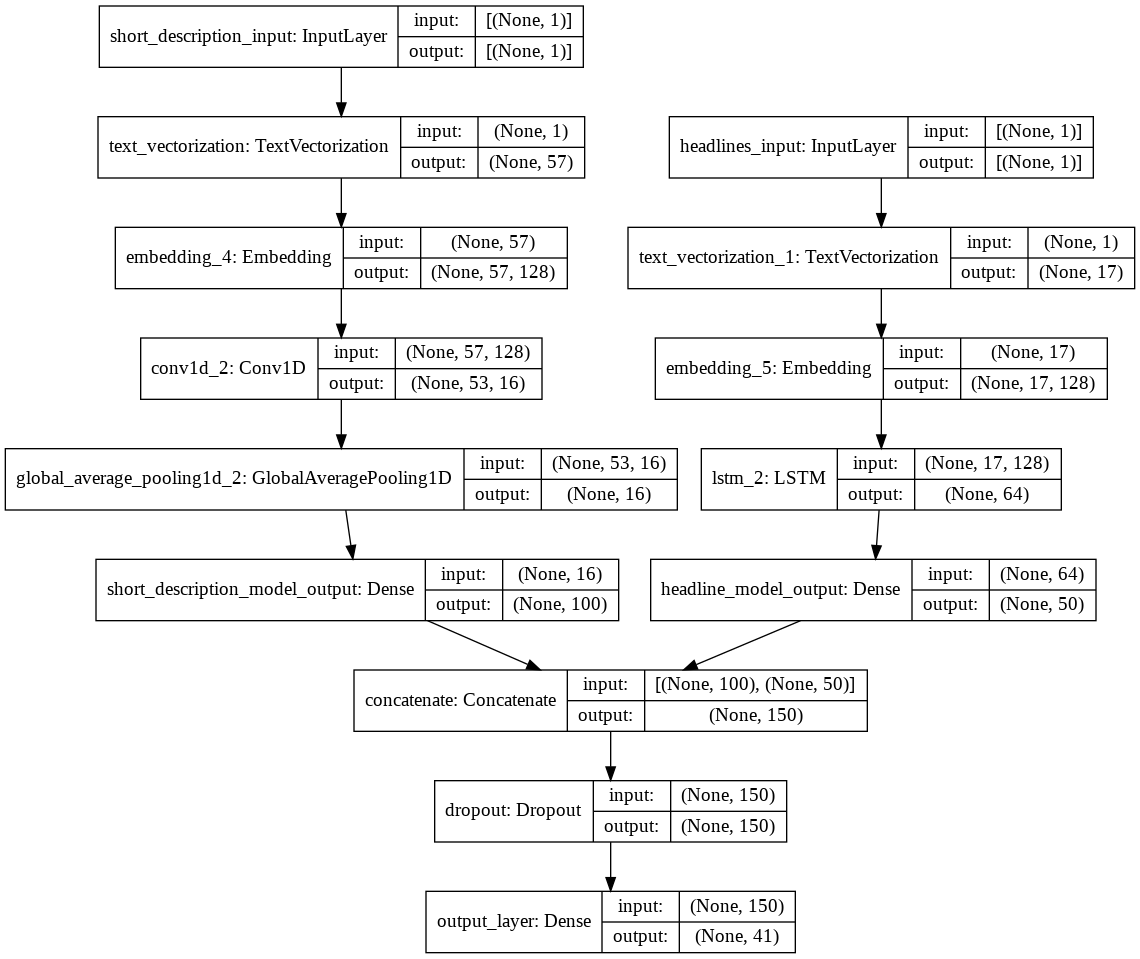

In [39]:
# plot model
from tensorflow.keras.utils import plot_model

plot_model(hybrid_model, show_shapes = True)

In [40]:
# fit the model
history_hybrid = hybrid_model.fit(train_dataset,
                                  epochs = 5,
                                  steps_per_epoch = int(0.1 * len(train_dataset)),
                                  validation_data = test_dataset,
                                  validation_steps = int(0.2*len(test_dataset)) # use 20% of test data for validation
                                  )

Epoch 1/5
502/502 [==============================] - 13s 21ms/step - loss: 3.1392 - accuracy: 0.2170 - val_loss: 2.8354 - val_accuracy: 0.2837
Epoch 2/5
502/502 [==============================] - 10s 20ms/step - loss: 2.7722 - accuracy: 0.3024 - val_loss: 2.6028 - val_accuracy: 0.3332
Epoch 3/5
502/502 [==============================] - 10s 20ms/step - loss: 2.5978 - accuracy: 0.3383 - val_loss: 2.4746 - val_accuracy: 0.3574
Epoch 4/5
502/502 [==============================] - 10s 19ms/step - loss: 2.5110 - accuracy: 0.3584 - val_loss: 2.4153 - val_accuracy: 0.3800
Epoch 5/5
502/502 [==============================] - 10s 19ms/step - loss: 2.4371 - accuracy: 0.3818 - val_loss: 2.3265 - val_accuracy: 0.4016


In [41]:
# evaluate hybrid model on test data
hybrid_results = hybrid_model.evaluate(test_dataset)

1256/1256 [==============================] - 9s 7ms/step - loss: 2.3210 - accuracy: 0.4056


# Transfer learning using pretrained encoder

model used:

universal-sentence-encoder

https://tfhub.dev/google/universal-sentence-encoder/4


In [42]:
import tensorflow_hub as hub

embed_description = sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                                              input_shape=[],
                                                              dtype=tf.string, 
                                                              trainable=False,)
embed_headline = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                                              input_shape=[],
                                                              dtype=tf.string, 
                                                              trainable=False,)

In [43]:
# short description model
short_description_inputs = tf.keras.layers.Input(shape = [], dtype = tf.string, name = "short_description_input")
embed = embed_description(short_description_inputs)
short_description_outputs = tf.keras.layers.Dense(100, activation = "relu", name = "short_description_model_output")(embed)

# headlines model
headline_inputs = tf.keras.layers.Input(shape = [], dtype = tf.string, name = "headlines_input")
embed = embed_headline(headline_inputs)
headline_outputs = tf.keras.layers.Dense(50, activation = "relu", name = "headline_model_output")(embed)

# concatenate short description and headline outputs
x = tf.keras.layers.Concatenate()([short_description_outputs, headline_outputs])

# add dropout layer to avoid overfitting
x = tf.keras.layers.Dropout(0.5)(x)

# output layer
outputs = tf.keras.layers.Dense(len(class_names), activation = "softmax", name = "output_layer")(x)



# create hybrid model
hybrid_model_use = tf.keras.Model(inputs = [headline_inputs, short_description_inputs], outputs = outputs)

# compile model
hybrid_model_use.compile(optimizer = tf.keras.optimizers.Adam(),
                     loss = tf.keras.losses.categorical_crossentropy,
                     metrics = ["accuracy"])

# check model summary
hybrid_model_use.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
short_description_input (InputL [(None,)]            0                                            
__________________________________________________________________________________________________
headlines_input (InputLayer)    [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        (None, 512)          256797824   short_description_input[0][0]    
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      (None, 512)          256797824   headlines_input[0][0]            
____________________________________________________________________________________________

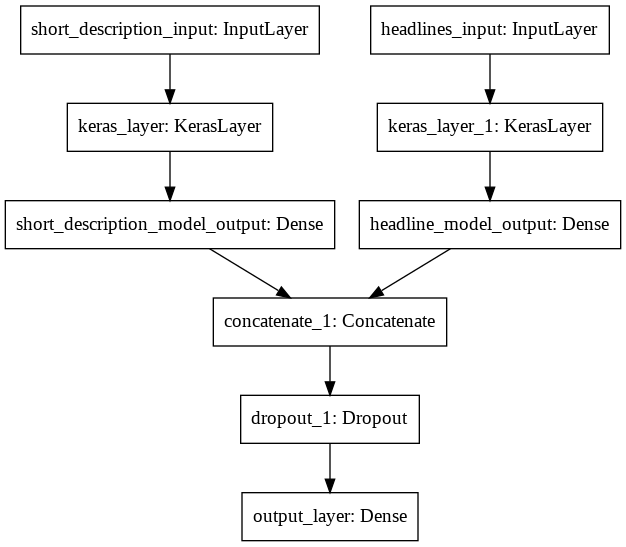

In [44]:
# plot model

plot_model(hybrid_model_use, show_shapes = False)

In [45]:
# fit the model
history_hybrid_use = hybrid_model_use.fit(train_dataset,
                                          epochs = 5,
                                          steps_per_epoch = int(0.1*len(train_dataset)),
                                          validation_data = test_dataset,
                                          validation_steps = int(0.2*len(test_dataset)), # use 20% of test data for validation
                                          )

Epoch 1/5
502/502 [==============================] - 26s 41ms/step - loss: 2.7035 - accuracy: 0.3447 - val_loss: 2.1153 - val_accuracy: 0.4656
Epoch 2/5
502/502 [==============================] - 20s 39ms/step - loss: 2.0400 - accuracy: 0.4760 - val_loss: 1.7551 - val_accuracy: 0.5336
Epoch 3/5
502/502 [==============================] - 20s 39ms/step - loss: 1.8381 - accuracy: 0.5118 - val_loss: 1.6071 - val_accuracy: 0.5598
Epoch 4/5
502/502 [==============================] - 20s 39ms/step - loss: 1.7286 - accuracy: 0.5333 - val_loss: 1.5163 - val_accuracy: 0.5763
Epoch 5/5
502/502 [==============================] - 20s 41ms/step - loss: 1.6766 - accuracy: 0.5441 - val_loss: 1.4630 - val_accuracy: 0.5905


In [46]:
# evaluate model

hybrid_use_results = hybrid_model_use.evaluate(test_dataset)

1256/1256 [==============================] - 35s 28ms/step - loss: 1.4748 - accuracy: 0.5874


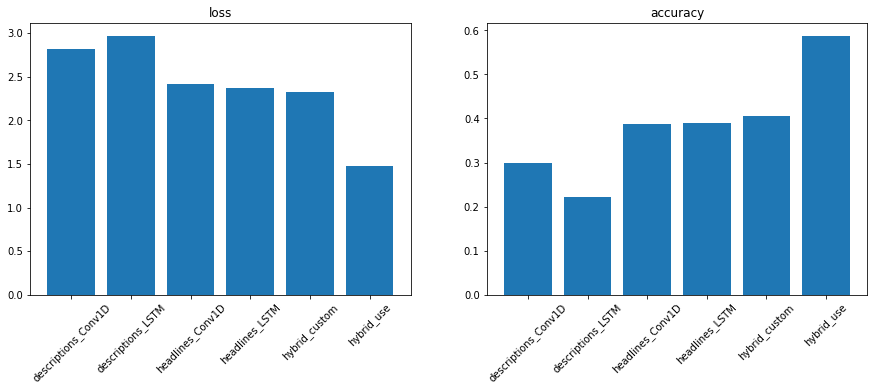

In [47]:
# compare model results using bar plots
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.bar(range(6),
        [descriptions_Conv1D_results[0],
         descriptions_LSTM_results[0],
         headlines_conv1D_results[0],
         headlines_LSTM_results[0],
         hybrid_results[0],
         hybrid_use_results[0]],
        tick_label = ["descriptions_Conv1D",
                      "descriptions_LSTM",
                      "headlines_Conv1D",
                      "headlines_LSTM",
                      "hybrid_custom",
                      "hybrid_use"]
        )
plt.title("loss")
plt.xticks(rotation = 45)

plt.subplot(1,2,2)

plt.bar(range(6),
        [descriptions_Conv1D_results[1],
         descriptions_LSTM_results[1],
         headlines_conv1D_results[1],
         headlines_LSTM_results[1],
         hybrid_results[1],
         hybrid_use_results[1]],
        tick_label = ["descriptions_Conv1D",
                      "descriptions_LSTM",
                      "headlines_Conv1D",
                      "headlines_LSTM",
                      "hybrid_custom",
                      "hybrid_use"]
        )
plt.title("accuracy")
plt.xticks(rotation = 45)

plt.show()

# Training best model on 100% of train dataset

looks like our hybrid model with pretrained encoders got best results, let's train it on 100% of train dataset

recreate model

In [48]:
# short description model
short_description_inputs = tf.keras.layers.Input(shape = [], dtype = tf.string, name = "short_description_input")
embed = embed_description(short_description_inputs)
short_description_outputs = tf.keras.layers.Dense(100, activation = "relu", name = "short_description_model_output")(embed)

# headlines model
headline_inputs = tf.keras.layers.Input(shape = [], dtype = tf.string, name = "headlines_input")
embed = embed_headline(headline_inputs)
headline_outputs = tf.keras.layers.Dense(50, activation = "relu", name = "headline_model_output")(embed)

# concatenate short description and headline outputs
x = tf.keras.layers.Concatenate()([short_description_outputs, headline_outputs])

# add dropout layer to avoid overfitting
x = tf.keras.layers.Dropout(0.5)(x)

# output layer
outputs = tf.keras.layers.Dense(len(class_names), activation = "softmax", name = "output_layer")(x)



# create hybrid model
hybrid_model_use = tf.keras.Model(inputs = [headline_inputs, short_description_inputs], outputs = outputs)

# compile model
hybrid_model_use.compile(optimizer = tf.keras.optimizers.Adam(),
                     loss = tf.keras.losses.categorical_crossentropy,
                     metrics = ["accuracy"])

# check model summary
hybrid_model_use.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
short_description_input (InputL [(None,)]            0                                            
__________________________________________________________________________________________________
headlines_input (InputLayer)    [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        (None, 512)          256797824   short_description_input[0][0]    
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      (None, 512)          256797824   headlines_input[0][0]            
____________________________________________________________________________________________

In [49]:
# fit the model
history_hybrid_use = hybrid_model_use.fit(train_dataset,
                                          epochs = 5,
                                          steps_per_epoch = len(train_dataset),
                                          validation_data = test_dataset,
                                          validation_steps = int(0.2*len(test_dataset)), # use 20% of test data for validation
                                          )

Epoch 1/5
5022/5022 [==============================] - 154s 30ms/step - loss: 1.8061 - accuracy: 0.5177 - val_loss: 1.3499 - val_accuracy: 0.6122
Epoch 2/5
5022/5022 [==============================] - 151s 30ms/step - loss: 1.5161 - accuracy: 0.5751 - val_loss: 1.2802 - val_accuracy: 0.6276
Epoch 3/5
5022/5022 [==============================] - 149s 30ms/step - loss: 1.4710 - accuracy: 0.5856 - val_loss: 1.2513 - val_accuracy: 0.6353
Epoch 4/5
5022/5022 [==============================] - 149s 30ms/step - loss: 1.4475 - accuracy: 0.5901 - val_loss: 1.2373 - val_accuracy: 0.6366
Epoch 5/5
5022/5022 [==============================] - 149s 30ms/step - loss: 1.4306 - accuracy: 0.5937 - val_loss: 1.2269 - val_accuracy: 0.6388


# Fine-tuning

Makins USE layers trainable and fine-tuning our model

In [50]:
embed_description.trainable = True
embed_headline.trainable = True

# recompile model to apply changes

hybrid_model_use.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), # use lower learning rate while fine-tuning
                     loss = tf.keras.losses.categorical_crossentropy,
                     metrics = ["accuracy"])

# check model summary
hybrid_model_use.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
short_description_input (InputL [(None,)]            0                                            
__________________________________________________________________________________________________
headlines_input (InputLayer)    [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        (None, 512)          256797824   short_description_input[0][0]    
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      (None, 512)          256797824   headlines_input[0][0]            
____________________________________________________________________________________________

In [51]:
# fit the model
history_hybrid_use_fine_tuning = hybrid_model_use.fit(train_dataset,
                                                      epochs = 7,
                                                      initial_epoch = 5,
                                                      steps_per_epoch = len(train_dataset),
                                                      validation_data = test_dataset,
                                                      validation_steps = int(0.2*len(test_dataset)), # use 20% of test data for validation
                                                      )

Epoch 6/7
5022/5022 [==============================] - 2302s 456ms/step - loss: 1.3839 - accuracy: 0.6053 - val_loss: 1.1764 - val_accuracy: 0.6521
Epoch 7/7
5022/5022 [==============================] - 2292s 456ms/step - loss: 1.2039 - accuracy: 0.6521 - val_loss: 1.1410 - val_accuracy: 0.6594


In [52]:
# evaluate model
hybrid_model_use.evaluate(test_dataset)

1256/1256 [==============================] - 33s 26ms/step - loss: 1.1642 - accuracy: 0.6559


[1.164182424545288, 0.6558960676193237]

# Analyze model's results

Text(0, 0.5, 'accuracy')

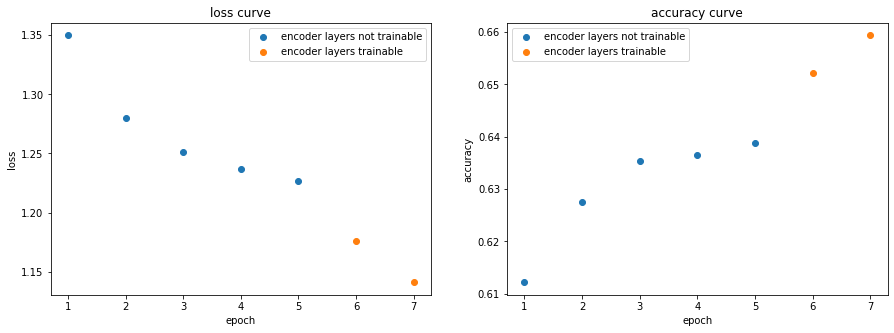

In [77]:
# plot loss and accuracy curves

loss = history_hybrid_use.history["val_loss"]
accuracy = history_hybrid_use.history["val_accuracy"]

loss_fine_tuning = history_hybrid_use_fine_tuning.history["val_loss"]
accuracy_fine_tuning = history_hybrid_use_fine_tuning.history["val_accuracy"]

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.scatter(range(1,6), loss)
plt.scatter([6,7], loss_fine_tuning)
plt.legend(["encoder layers not trainable", "encoder layers trainable"])
plt.title("loss curve")
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(1,2,2)
plt.scatter(range(1,6), accuracy)
plt.scatter([6,7], accuracy_fine_tuning)
plt.legend(["encoder layers not trainable", "encoder layers trainable"])
plt.title("accuracy curve")
plt.xlabel("epoch")
plt.ylabel("accuracy")


In [83]:
# get model predictions and true labels
true_labels = []
predictions = []

for data, label in test_dataset.take(-1):
  true_labels.append(label)
  predictions.append(tf.argmax(hybrid_model_use.predict(data), axis = 1))

true_labels = np.concatenate(true_labels)
predictions = np.concatenate(predictions)  

In [86]:
true_labels = tf.argmax(true_labels, axis = 1)

In [87]:
true_labels[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([37,  6, 26, 24, 38, 22, 10, 33, 38, 40])>

In [149]:
predictions[:10]

array([37,  2, 26, 24, 18, 22, 10, 33, 38, 40])

In [150]:
# get classification report
from sklearn.metrics import classification_report

print(classification_report(true_labels, predictions, target_names=class_names))

                precision    recall  f1-score   support

          ARTS       0.53      0.38      0.44       316
ARTS & CULTURE       0.56      0.23      0.33       269
  BLACK VOICES       0.54      0.38      0.45       897
      BUSINESS       0.53      0.51      0.52      1177
       COLLEGE       0.54      0.31      0.39       241
        COMEDY       0.60      0.39      0.47       988
         CRIME       0.57      0.59      0.58       667
CULTURE & ARTS       0.50      0.33      0.39       217
       DIVORCE       0.78      0.75      0.77       660
     EDUCATION       0.50      0.30      0.37       195
 ENTERTAINMENT       0.64      0.80      0.71      3227
   ENVIRONMENT       0.53      0.36      0.43       261
         FIFTY       0.48      0.11      0.17       292
  FOOD & DRINK       0.64      0.84      0.73      1219
     GOOD NEWS       0.44      0.19      0.26       309
         GREEN       0.44      0.38      0.41       488
HEALTHY LIVING       0.51      0.40      0.45  